# Import

In [140]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers

In [16]:
SEED = 0

In [9]:
# DataFrame
URL = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
# Column names of the DataFrame
column_names = ['MPG', 'Cylinders', 'Displacement',
                'Horsepower', 'Weight', 'Acceleration', 
                'Model Year', 'Origin']

# Importing DataFrame
dataset = pd.read_csv(URL, names=column_names, na_values='?',
                    comment='\t', sep=' ', skipinitialspace=True,
                    dtype_backend='pyarrow')

In [3]:
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [14]:
# Cleanning data
dataset =   dataset.dropna()

# Convert categorical 'Origin' data into one-hot data
dataset[['USA', 'Europe', 'Japan']] = pd.get_dummies(dataset['Origin']).astype('int8[pyarrow]')
dataset.drop(columns=['Origin'], errors='ignore', inplace=True)

In [15]:
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1,0,0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0,1,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1,0,0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1,0,0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1,0,0


In [17]:
# Splitting data into train and test
train = dataset.sample(frac=0.8, random_state=SEED)
test = dataset.drop(train.index)

train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [115]:
# Split features from labels
train_features = train.copy()
test_features = test.copy() 

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

In [116]:
def plot(feature, x=None, y=None):
    plt.figure(figsize=(10,8))
    plt.scatter(train_features[feature], train_labels, label='Data')
    if(
        x is not None
        and y is not None
):
        plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel(feature)
    plt.ylabel('MPG')
    plt.legend()

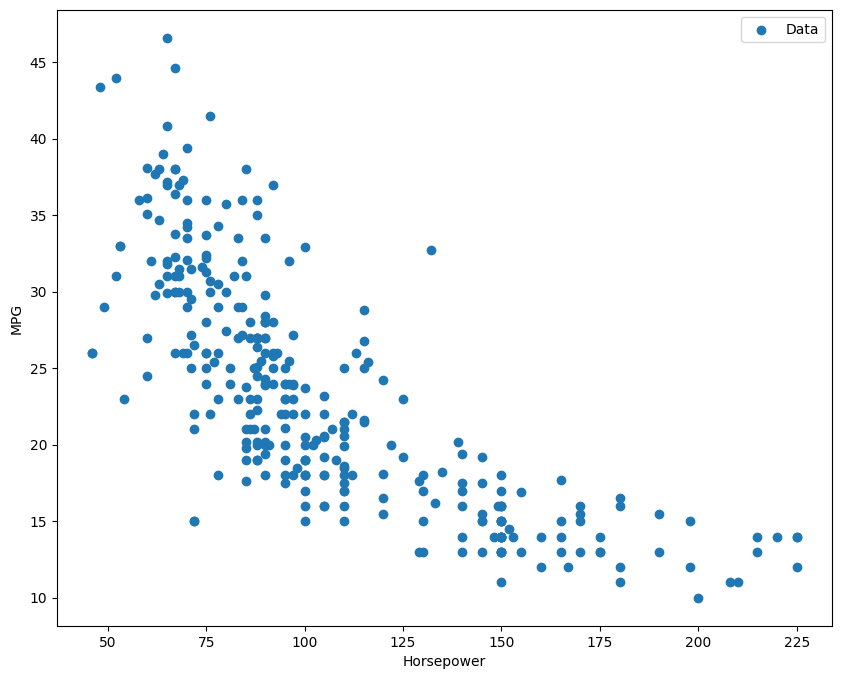

In [117]:
plot('Horsepower')

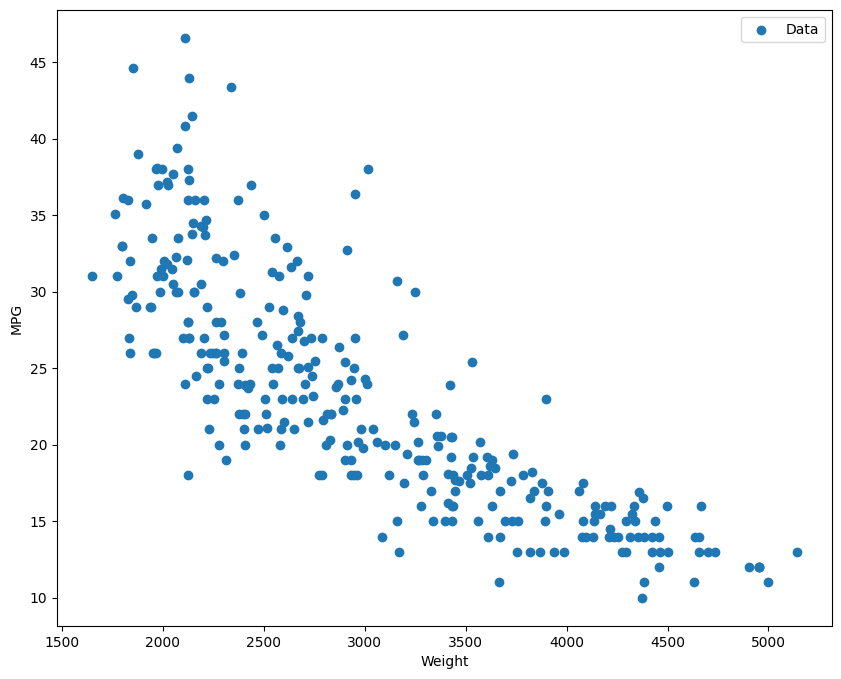

In [118]:
plot('Weight')

In [141]:
# Normalize 
normalizer = layers.Normalization(axis=-1)
normalizer.adapt(train_features.to_numpy(dtype=np.float32))
print(normalizer.mean.numpy())

[[5.47770691e+00 1.95318497e+02 1.04869446e+02 2.99025171e+03
  1.55592356e+01 7.58980942e+01 6.24203861e-01 1.78343967e-01
  1.97452217e-01]]


In [142]:
# Single Feature Normalizer 
single_feature = np.array(train_features[['Horsepower']], dtype='float32')

# Normalization
single_feature_normalizer = layers.Normalization(input_shape=[1,], axis=-1)

# Adapting to the Data
single_feature_normalizer.adapt(single_feature)

In [143]:
single_feature_model = keras.models.Sequential([
    single_feature_normalizer,
    keras.layers.Dense(units=1)
])

single_feature_model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_51 (Normaliz  (None, 1)                 3         
 ation)                                                          
                                                                 
 dense_19 (Dense)            (None, 1)                 2         
                                                                 
Total params: 5 (24.00 Byte)
Trainable params: 2 (8.00 Byte)
Non-trainable params: 3 (16.00 Byte)
_________________________________________________________________


In [144]:
loss = keras.losses.MeanAbsoluteError()
optimizer = keras.optimizers.legacy.Adam(learning_rate=0.1)

In [145]:
single_feature_model.compile(optimizer=optimizer, loss=loss)

In [146]:
history = single_feature_model.fit(
    single_feature, train_labels,
    epochs=100, 
    verbose=1,
    validation_split=0.2
)

Epoch 1/100
8/8 [==============================] - 0s 16ms/step - loss: 22.8671 - val_loss: 22.9382
Epoch 2/100
8/8 [==============================] - 0s 4ms/step - loss: 22.0618 - val_loss: 22.1385
Epoch 3/100
8/8 [==============================] - 0s 4ms/step - loss: 21.2613 - val_loss: 21.3384
Epoch 4/100
8/8 [==============================] - 0s 5ms/step - loss: 20.4609 - val_loss: 20.5385
Epoch 5/100
8/8 [==============================] - 0s 4ms/step - loss: 19.6608 - val_loss: 19.7385
Epoch 6/100
8/8 [==============================] - 0s 4ms/step - loss: 18.8608 - val_loss: 18.9385
Epoch 7/100
8/8 [==============================] - 0s 5ms/step - loss: 18.0623 - val_loss: 18.1383
Epoch 8/100
8/8 [==============================] - 0s 5ms/step - loss: 17.2617 - val_loss: 17.3385
Epoch 9/100
8/8 [==============================] - 0s 10ms/step - loss: 16.4616 - val_loss: 16.5386
Epoch 10/100
8/8 [==============================] - 0s 7ms/step - loss: 15.6748 - val_loss: 15.7416
Epoch 1

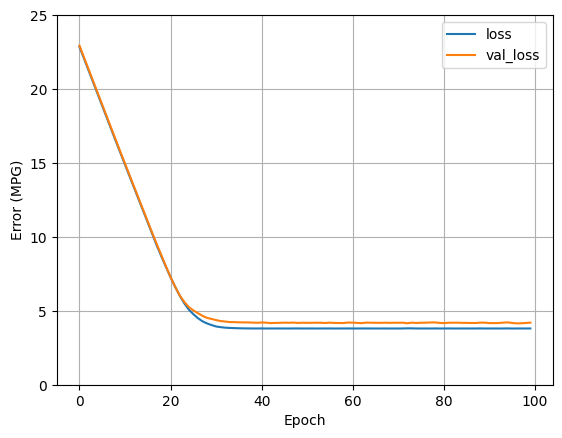

In [150]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim((0, 25))
    plt.xlabel('Epoch')
    plt.ylabel('Error (MPG)')
    plt.legend()
    plt.grid(True)
    plt.show()
plot_loss(history)

In [153]:
feature = 'Horsepower'

In [151]:
single_feature_model.evaluate(test_features['Horsepower'], test_labels,
                            verbose=1)

3/3 [==============================] - 0s 5ms/step - loss: 3.6450


3.6450109481811523

7/7 [==============================] - 0s 909us/step


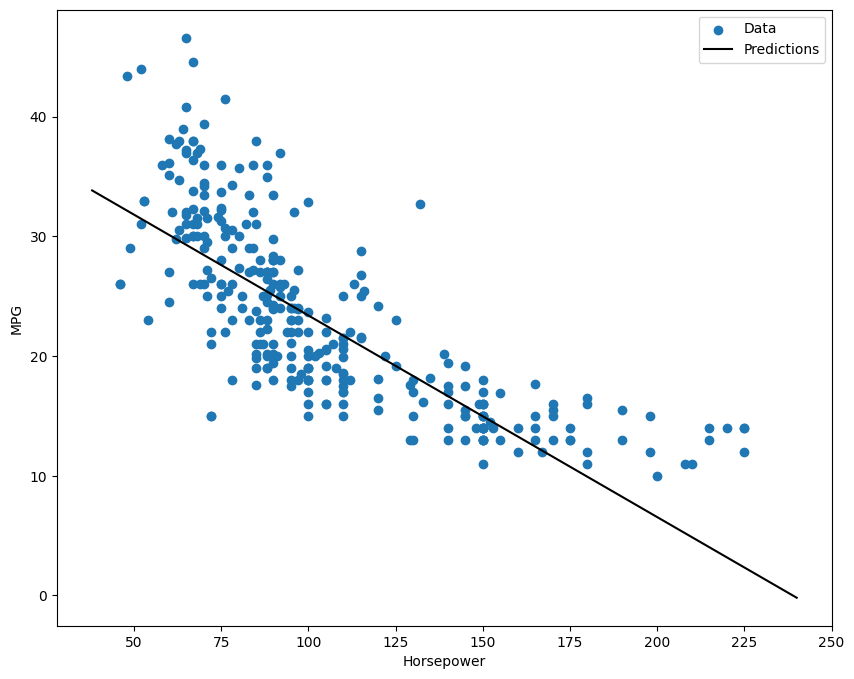

In [154]:
range_min = np.min(test_features[feature]) - 10
range_max = np.max (test_features[feature]) + 10
x = tf.linspace(range_min, range_max, 200)
y = single_feature_model.predict(x)
plot(feature, x,y)